In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
#!pip 

     |████████████████████████████████| 53 kB 1.4 MB/s 
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-exoickx9
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-exoickx9
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369387 sha256=42c8a92c199ce86d1da2eb334fa2f8342940a0884bb6908738120f20ae697608
  Stored in directory: /tmp/pip-ephem-wheel-cache-7a00v1md/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
!nvidia-smi

Mon May 16 07:24:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
from collections import OrderedDict
import IPython.display
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import clip

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import numpy as np
from tensorflow.keras.utils import load_img

class ArtLoader:
    """Load in art from artists as an array, batched and ready for tf"""
    
    def __init__(self):
        pass

    def get_image_single(self, path_to_image):
        """read in a single image, as an np array with dataset dim"""
        img = load_img(path_to_image).convert('RGB') 
        return np.expand_dims(img, 0)

    def get_all_from_artist(self, artist_name):
        """read in images from the prompts: 
        'A beautiful painting of a waterlily pond, {artist}, Trending on artstation', 
        'A beautiful painting of a building in a serene landscape, {artist}, Trending on artstation'
        for a particluar artist"""
        all_img_paths = os.listdir(f'{self.data_path}/{artist_name}')
        pond_img_list = [load_img(f'{self.data_path}/{artist_name}/{img_path}').convert('RGB') 
                         for img_path in all_img_paths  
                         if img_path.endswith('png')]
        return np.array(pond_img_list)


    def get_image_folders(self, data_path, exclude_list, num_artists = None, preprocessor = None):
        """set the path to the data directory
        loop through all artists and load images
        optionally process, eg for clip"""

        self.art_list = []
        self.preprocessed_art_list = []
        self.artist_list = []
        self.data_path = data_path
        self.preprocessor = preprocessor

        if self.data_path[-1] == '/':
            self.data_path = self.data_path[:-1]

        exclude_list.append('.DS_Store')

        self.all_artists = [artist for artist in os.listdir(self.data_path) if artist not in exclude_list]

        if num_artists:
          self.all_artists = self.all_artists[:num_artists]
        for artist in tqdm(self.all_artists):

            for art in self.get_all_from_artist(artist):
                self.artist_list.append(artist)
                self.art_list.append(art)
                if preprocessor:
                    self.preprocessed_art_list.append(self.preprocessor(art))
        
        art_loader.art_list = np.array(art_loader.art_list, dtype=object)
        art_loader.artist_list = np.array(art_loader.artist_list, dtype=object)



    def encode_art_to_features(self, model):
        """turn images into features using a pretrained neural net
        eg clip because thats what most art models use"""

        if self.preprocessor:
          art_array = np.stack(self.preprocessed_art_list)
        else:
          art_array = np.stack(self.art_list)

        image_input = torch.tensor(art_array).cuda()
          
        with torch.no_grad():
            features = model.encode_image(image_input).float()

        return features.cpu().numpy()

In [6]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.image import resize


def show_xy_images(in_df, imgs, image_zoom=1):
    fig, ax1 = plt.subplots(1,1, figsize=(16, 16))
    artists = []
    for idx, c_row in tqdm(in_df.reset_index().iterrows()):
        #c_img = Image.open(c_row['path']).resize((64, 64))
        c_img = resize(img_to_array(imgs[idx]), [50,50]) / 255.0
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (c_row['pc1'], c_row['pc2']), xycoords='data', frameon=False)
        artists.append(ax1.add_artist(ab))
    ax1.update_datalim(in_df[['pc1', 'pc2']])
    ax1.autoscale()
    #ax1.axis('off')
#show_xy_images(pcs_df[ponds], imgs = np.array(ponds_list, dtype=object)[ponds])

In [7]:
# Torch - features w clip
print(clip.available_models())

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 47.3MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [8]:
# TF  - fetures w resnet
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Resizing
# from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.applications.resnet50 import ResNet50

# #tf.keras.applications.resnet50.preprocess_input

# from tensorflow.keras.utils import img_to_array

# #img_to_array()

# topless_resnet = ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(224, 224, 3),
#     pooling='max' #avg, max
# )

# model = Sequential([
#     Resizing(224, 224),
#     topless_resnet
# ])

In [9]:
art_loader = ArtLoader()

# load data

exclude = ['styles single images', 'non-visual artist single images']

art_loader.get_image_folders(data_path = 'drive/My Drive/datasets/artist_studies/batch 1',
                             exclude_list = exclude,
                             num_artists = None, 
                             preprocessor = preprocess)

len(art_loader.all_artists)


clip_features = art_loader.encode_art_to_features(model)


clip_features.shape

  0%|          | 0/142 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 142/142 [06:08<00:00,  2.60s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56

(912, 512)

In [10]:
# import tensorflow_transform as tft
# import tensorflow as tf
# results = tft.pca(test_features, 2, tf.float32)

In [ ]:
class ConvColour:

  def __init__():
    pass

  

In [377]:
from tensorflow.image import resize
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.layers import Resizing

colour_feat_list = []
for art in art_loader.art_list:

  colour_feat_list.append(resize(img_to_array(art), [240,240]))
art_array = np.stack(colour_feat_list)

mean_colour_features = art_array.mean(axis = (1, 2))

In [379]:
art_array.shape

(912, 240, 240, 3)

In [378]:
def colours_as_pct(input_images):
    images = input_images.copy()
    # add so we can't divide by zero
    images += 1
    images = np.true_divide(images, images.sum(axis=3, keepdims=True))
    return images

In [303]:
np.isnan(art_array).sum()

0

In [304]:
#art_array = colours_as_pct(art_array)

np.isnan(art_array).sum()

0

In [141]:
# use conv to extract different colours from the image


[30, 30]
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 240, 240, 3)]     0         
                                                                 
 conv2d_32 (Conv2D)          (None, 8, 8, 3)           8103      
                                                                 
 flatten_27 (Flatten)        (None, 192)               0         
                                                                 
Total params: 8,103
Trainable params: 8,103
Non-trainable params: 0
_________________________________________________________________


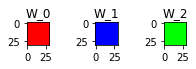

In [398]:
# conv to pull out patches of colour
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Rescaling
from tensorflow.keras import Input, Model
from tensorflow.keras.regularizers import L2
import tensorflow as tf

def colour_extractor(input_shape, n_cut):

    kernel_shape = [int(input_dim / n_cut) for input_dim in input_shape[:2]]
    print(kernel_shape)
    input = Input(shape = input_shape)
    #pct_input = tf.function(colours_as_pct(input))
    output = Conv2D(3, kernel_size = kernel_shape, activation = 'relu', strides = kernel_shape, padding = 'same')(input)
    #output = MaxPooling2D(6)(output)
    flattened_output = Flatten()(output)
    model = Model(input, flattened_output)

    red = np.stack([np.ones(kernel_shape), np.zeros(kernel_shape), np.zeros(kernel_shape)], axis = -1)
    green = np.stack([np.zeros(kernel_shape), np.ones(kernel_shape), np.zeros(kernel_shape)], axis = -1)
    blue = np.stack([np.zeros(kernel_shape), np.zeros(kernel_shape), np.ones(kernel_shape)], axis = -1)

    # plot weights
    fig, axes = plt.subplots(1, 3, figsize = (3, 1))
    for i, ax, colour in zip(range(3), axes, [red, blue, green]):
      ax.imshow(colour)
      ax.set_title(f'W_{i}')
    plt.tight_layout()

    colour_weights = np.stack([red, green, blue], axis = 2)

    model.layers[1].set_weights([colour_weights, model.layers[1].get_weights()[1]])

    return model


model = colour_extractor(input_shape = (240, 240, 3), n_cut = 8)
model.summary()

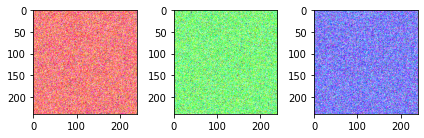

In [399]:
def create_skewed_image(channel, scalar, shape):
    random_img = np.random.randint(low = 0, high = 255, size = (shape[0] * shape[1] * 3)).reshape((shape[0], shape[1], 3))

    random_img[:, :, channel] = np.clip((random_img[:, :, channel] * scalar), a_min = 0, a_max = 255)
    return random_img

def create_test_dataset(image_shape):
    # create test dataset
    dataset_list = []

    for i in range(3):
      dataset_list.append(create_skewed_image(channel = i, scalar = 10, shape = image_shape))
    test_dataset = np.array(dataset_list)

    fig, axes = plt.subplots(1, 3, figsize = (6, 2))
    for ax, colour in zip(axes, test_dataset):
      ax.imshow(colour)
    plt.tight_layout();

    return test_dataset

test_dataset = create_test_dataset((240, 240))

In [415]:
#colour_features = np.concatenate([model(art_array), model(colours_as_pct(art_array))], axis = -1)
colour_features = model(colours_as_pct(art_array))
colour_features.shape

TensorShape([912, 192])

In [401]:
# getting more colour features, get rgb of top 10 colours in image
# colour order shouldnt matter, features compare them incorrectly
# use conv layer to find colours

In [ ]:
#img_colours = feat_color_arr.reshape(912, -1, 3)

# from sklearn.cluster import KMeans
# k_cluster = KMeans(5)
# img_colours_list = []
# for img in tqdm(img_colours[:300]):
#   print(img.shape)
#   k_cluster.fit(img)

#   colour_feature_list = []
#   for label in np.unique(k_cluster.labels_):
#     colour_feature_list.append(img[k_cluster.labels_ == label].mean(axis = 0))
#     print(colour_feature_list)
#     colour_feature_arr = np.array([feat for feat in colour_feature_list])
#     print(colour_feature_arr)
#     pca_colours = PCA(1)
#     colour_pc = pca_colours.fit_transform(colour_feature_arr)
#     colour_feature_list.append(colour_pc)

#   img_colours_list.append(colour_feature_list)

# many_colour_features = np.stack(img_colours_list)

In [416]:
all_features = np.concatenate((colour_features, clip_features), axis = 1)
all_features.shape

(912, 704)

In [417]:
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
clip_features_scaled = s_scaler.fit_transform(clip_features)
all_features_scaled = s_scaler.fit_transform(all_features)
colour_features_scaled = s_scaler.fit_transform(colour_features)
# many_colour_features_scaled = s_scaler.fit_transform(many_colour_features)

In [418]:
#all_features_scaled[:, -3:] = all_features_scaled[:, -3:] * 5

In [419]:
all_features_scaled.shape

(912, 704)

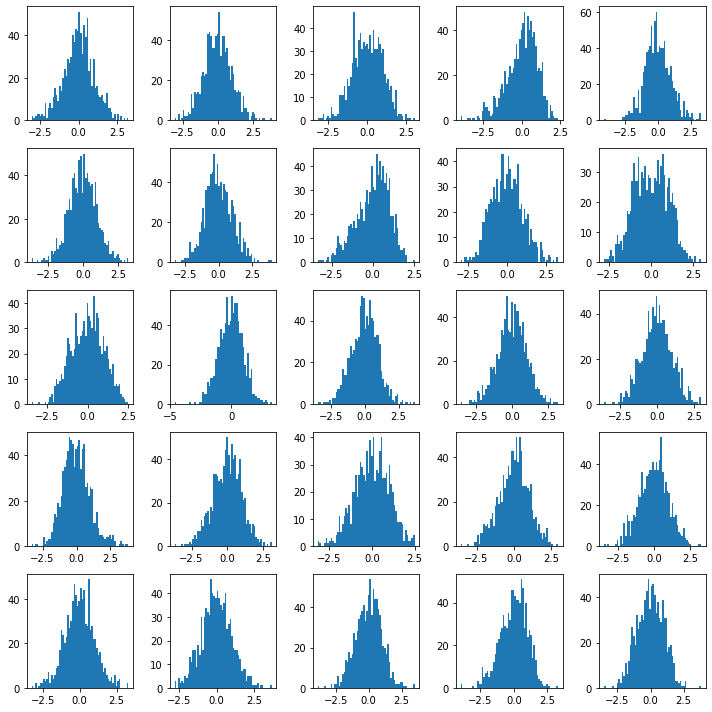

In [420]:
# plot first 25 scaled clip features
fig, axes = plt.subplots(5, 5, figsize = (10, 10))
for ax, i in zip(axes.flat, range(25)):
  ax.hist(all_features_scaled[:, -(i + 1)], bins = 60);
plt.tight_layout()

In [421]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def split_ponds_buildings(data, artists_list):
  num_pcs = data.shape[-1]
  pca = PCA(num_pcs)
  pcs = pca.fit_transform(data)

  pcs_dict = {f'pc{i+1}': pcs[:, i] for i in range(num_pcs)}
  pcs_dict['artist'] = artists_list

  pcs_df = pd.DataFrame(pcs_dict)
  
  k_cluster = KMeans(2)
  k_cluster.fit(pcs)
  pcs_df['k_labels'] = k_cluster.labels_

  ponds_mask = (pcs_df['k_labels'] == 1).values
  ponds = pcs_df[ponds_mask]

  buildings_mask = (pcs_df['k_labels'] == 0).values
  buildings = pcs_df[buildings_mask]

  plotting_sample = pcs_df.sample(300)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
  sns.scatterplot(data = plotting_sample, x = 'pc1', y = 'pc2', hue = 'artist', ax = ax1)
  ax1.set_title('Before Clustering - by artist')
  ax1.legend('')
  sns.scatterplot(data = plotting_sample, x = 'pc1', y = 'pc2', hue = 'k_labels', ax = ax2)
  ax2.set_title('After Kmeans Clustering')
  ax2.legend('')

  return ponds, ponds_mask, buildings, buildings_mask

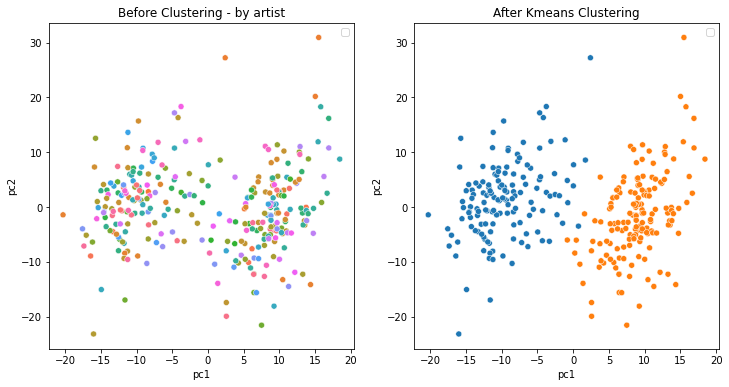

In [422]:
ponds, ponds_mask, buildings, buildings_mask = split_ponds_buildings(all_features_scaled, artists_list = art_loader.artist_list)

In [423]:
# colour_ponds = colour_features_scaled[ponds_mask]
# colour_buildings = colour_features_scaled[buildings_mask]
# many_colour_ponds = many_colour_features_scaled[ponds_mask]
# many_colour_buildings = many_colour_features_scaled[buildings_mask]

In [410]:
ponds.shape

(476, 898)

In [296]:
# autoencoder only ponds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras.regularizers import L2

#model = Sequential()

def build_encoder(latent_dim, input_shape):

    input = Input(shape = input_shape)

    x = Dense(64, activation = 'sigmoid')(input)
    x = Dense(32, activation = 'sigmoid')(x) # , activity_regularizer=L2(0.1)
    output = Dense(latent_dim, activation = 'tanh')(x)

    model = Model(input, output)

    return model

def build_decoder(latent_dim, input_shape):

    input = Input(shape = (latent_dim, ))

    x = Dense(32, activation = 'sigmoid')(input)
    x = Dense(64, activation = 'sigmoid')(x)
    output = Dense(input_shape[0], activation = 'tanh')(x)

    model = Model(input, output)

    return model


def combine_autoencoder(encoder, decoder, input_shape):
    input_features = Input(shape = input_shape)
    encoded = encoder(input_features)
    decoded = decoder(encoded)
    autoencoder = Model(input_features, decoded)

    autoencoder.compile(loss = 'mse', 
                        optimizer = 'adam',)
    return autoencoder

0.678855836391449


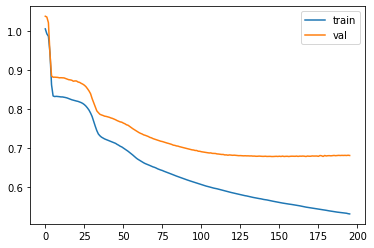

In [299]:
from tensorflow.keras.callbacks import EarlyStopping

encoder = build_encoder(200, input_shape = (515,))
decoder = build_decoder(200, input_shape = (515,))

autoencoder = combine_autoencoder(encoder, decoder, input_shape = (515,))

es = EarlyStopping(patience = 50, restore_best_weights = True)

history = autoencoder.fit(x = all_features_scaled, y = all_features_scaled, 
            epochs = 1000, 
            batch_size = 32,
            validation_split = 0.2,
            callbacks = [es]).history

import matplotlib.pyplot as plt
print(min(history['val_loss']))
plt.plot(history['loss'], label = 'train')
plt.plot(history['val_loss'], label = 'val')
plt.legend();

In [300]:
ponds_encoded = encoder.predict(ponds.iloc[:, :-2].values)
enc_pcs_ponds_dict = {f'pc{i+1}': ponds_encoded[:, i] for i in range(100)}
enc_pcs_ponds_dict['artist'] = art_loader.artist_list[ponds_mask]

enc_pcs_ponds_df = pd.DataFrame(enc_pcs_ponds_dict)

# show_xy_images(pcs_ponds_df, imgs = art_loader.art_list[ponds_mask])

pc1       pc2       pc3       pc4       pc5       pc6       pc7  \
0    0.378143  0.199658 -0.117254 -0.448868  0.203068  0.749896 -0.171622   
1   -0.055272 -0.125072 -0.029062 -0.497889 -0.161421  0.717437 -0.083410   
2    0.058713 -0.078790 -0.037393 -0.486809 -0.021058  0.767680 -0.098952   
3    0.377300  0.017363 -0.151128  0.211541  0.197173  0.720194 -0.600822   
4    0.423484  0.038788 -0.073200 -0.030993  0.163544  0.595177 -0.317236   
..        ...       ...       ...       ...       ...       ...       ...   
470  0.305205 -0.459541  0.202205  0.262546  0.271205  0.409242  0.095572   
471  0.000756 -0.390939  0.137433  0.011780 -0.129598  0.581558 -0.110194   
472  0.350317 -0.102561  0.299007  0.314267  0.366165  0.594201 -0.445016   
473  0.322905 -0.070847  0.225350  0.240136  0.281664  0.689947 -0.530645   
474  0.362612 -0.020680  0.178090  0.159927  0.329596  0.663781 -0.455081   

          pc8       pc9      pc10  ...      pc92      pc93      pc94  \
0   -0.093560 -0.237560  0.764645  ...  0.581993 -0.429818  0.334103   
1   -0.610519 -0.147720  0.903996  ...  0.266971  0.116145  0.336852   
2   -0.528893 -0.229040  0.896410  ...  0.309632 -0.003446  0.339226   
3   -0.220139  0.135806  0.672323  ... -0.172686 -0.312016  0.047874   
4   -0.343929  0.047351  0.584091  ... -0.240299  0.111364 -0.029555   
..        ...       ...       ...  ...       ...       ...       ...   
470 -0.242194 -0.075741  0.426070  ... -0.336279  0.198451  0.234554   
471 -0.582465  0.055214  0.804356  ... -0.265039  0.239012  0.410886   
472 -0.119491  0.284496  0.273167  ... -0.046866 -0.218702  0.021240   
473 -0.168758  0.275941  0.517042  ...  0.051132 -0.314445  0.038009   
474 -0.099235  0.196571  0.468444  ...  0.062590 -0.288157  0.050673   

         pc95      pc96      pc97      pc98      pc99     pc100  \
0    0.593552 -0.168022 -0.087417 -0.249750 -0.116905 -0.200076   
1    0.164242  0.054984  0.225513  0.153457 -0.053650  0.222528   
2    0.188020  0.025427  0.189960  0.054916 -0.022423  0.047422   
3   -0.091986 -0.031165 -0.352660 -0.546046  0.352060 -0.294606   
4   -0.238677  0.188221 -0.480227 -0.089395  0.328256  0.074019   
..        ...       ...       ...       ...       ...       ...   
470  0.076661  0.332756 -0.202054  0.097158  0.197209  0.359099   
471 -0.158199  0.331106  0.182443  0.083404 -0.034644  0.499063   
472  0.409638  0.113414 -0.431370 -0.412549  0.351914  0.324563   
473  0.406863  0.046893 -0.323276 -0.484537  0.387362  0.143053   
474  0.439524  0.044698 -0.382424 -0.471541  0.333930  0.089327   

                  artist  
0         Copley_William  
1         Copley_William  
2         Copley_William  
3    Arcimboldo_Giuseppe  
4    Arcimboldo_Giuseppe  
..                   ...  
470        Emshwiller_Ed  
471        Emshwiller_Ed  
472        Robert_Hubert  
473        Robert_Hubert  
474        Robert_Hubert  

[475 rows x 101 columns]

In [424]:
# pca only ponds
from sklearn.decomposition import PCA
num_pcs = 2
pca = PCA(num_pcs)
pcs_ponds = pca.fit_transform(ponds.iloc[:, :-2].values)

pcs_ponds_dict = {f'pc{i+1}': pcs_ponds[:, i] for i in range(num_pcs)}
pcs_ponds_dict['artist'] = art_loader.artist_list[ponds_mask]

pcs_ponds_df = pd.DataFrame(pcs_ponds_dict)

In [425]:
# pca only buildings
from sklearn.decomposition import PCA
num_pcs = 2
pca = PCA(num_pcs)
pcs_buildings = pca.fit_transform(buildings.iloc[:, :-2].values)

pcs_buildings_dict = {f'pc{i+1}': pcs_buildings[:, i] for i in range(num_pcs)}
pcs_buildings_dict['artist'] = art_loader.artist_list[buildings_mask]

pcs_buildings_df = pd.DataFrame(pcs_buildings_dict)

475it [00:05, 92.43it/s]


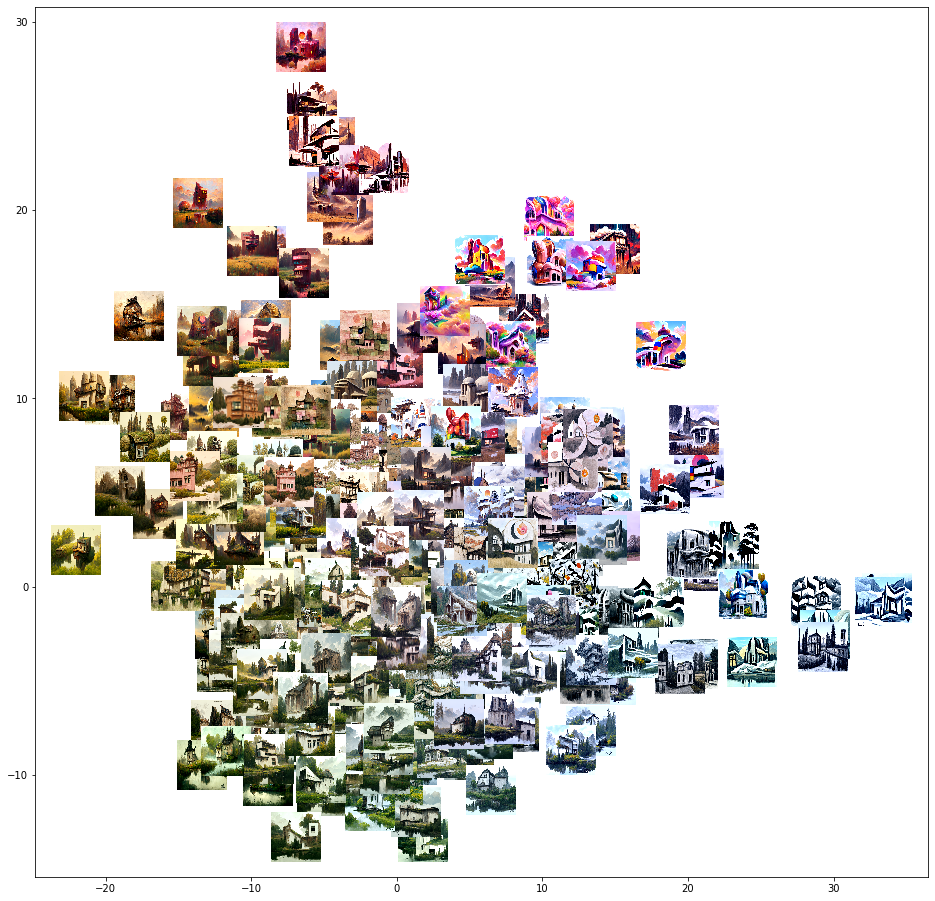

In [426]:
show_xy_images(pcs_ponds_df, imgs = art_loader.art_list[ponds_mask])

437it [00:05, 85.90it/s]


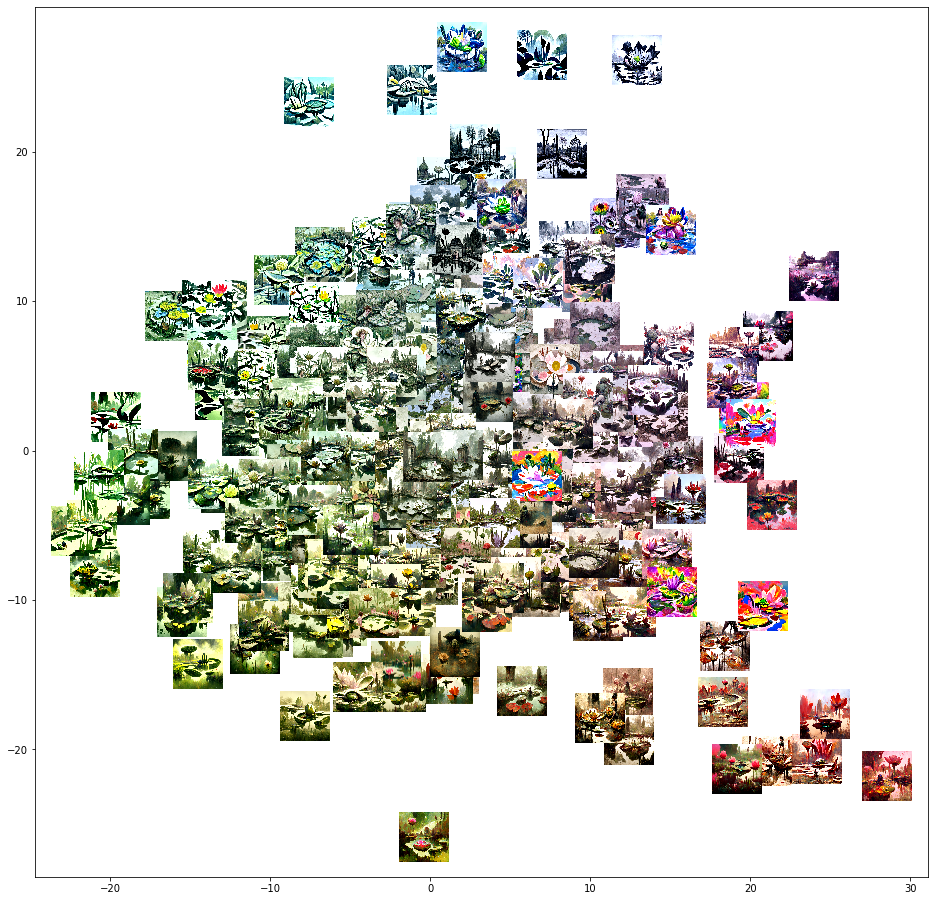

In [427]:
show_xy_images(pcs_buildings_df, imgs = art_loader.art_list[buildings_mask])

In [324]:
# pca only
from sklearn.decomposition import PCA
num_pcs = 2
pca = PCA(num_pcs)
pcs_ponds = pca.fit_transform(ponds.iloc[:, :-2].values)

pcs_ponds_dict = {f'pc{i+1}': pcs_ponds[:, i] for i in range(num_pcs)}
pcs_ponds_dict['artist'] = art_loader.artist_list[ponds_mask]

pcs_ponds_df = pd.DataFrame(pcs_ponds_dict)

In [236]:
ponds_df.iloc[:, :-1].values

array([[290.79907, 436.5424 , 872.64825],
       [282.70926, 441.71094, 875.5795 ],
       [293.8962 , 442.2112 , 863.8885 ],
       ...,
       [302.28296, 448.25845, 849.45807],
       [285.57373, 444.3399 , 870.0867 ],
       [288.879  , 440.06046, 871.05835]], dtype=float32)

In [249]:
np.isnan(colour_features_scaled[ponds_mask]).sum()

6615

In [310]:
colour_features_scaled.shape

(912, 108)

In [311]:


colour_features_scaled
# ponds_dict = {f'pc{i+1}': colour_features[ponds_mask][:, i] for i in range(3)}
# ponds_dict['artist'] = art_loader.artist_list[ponds_mask]

# ponds_df = pd.DataFrame(ponds_dict)

num_pcs = 2
pca = PCA(num_pcs)
pcs_ponds = pca.fit_transform(colour_features_scaled[ponds_mask])

pcs_ponds_dict = {f'pc{i+1}': pcs_ponds[:, i] for i in range(num_pcs)}
pcs_ponds_dict['artist'] = art_loader.artist_list[ponds_mask]

pcs_ponds_df = pd.DataFrame(pcs_ponds_dict)

#ponds_df.columns = ['pc1',	'pc1',	'pc',	'artist']

pcs_ponds_df

pc1       pc2               artist
0     2.810646 -0.553672       Copley_William
1    -1.014819 -4.185829       Copley_William
2     1.664510 -2.997237       Copley_William
3    -5.322085 -6.307767  Arcimboldo_Giuseppe
4    -5.525530 -0.950801  Arcimboldo_Giuseppe
..         ...       ...                  ...
470  13.037716  6.416586        Emshwiller_Ed
471  11.525449 -4.105417        Emshwiller_Ed
472   2.304387  1.877253        Robert_Hubert
473  -1.134580 -2.197949        Robert_Hubert
474  -1.453270 -3.750340        Robert_Hubert

[475 rows x 3 columns]

475it [00:05, 94.51it/s]


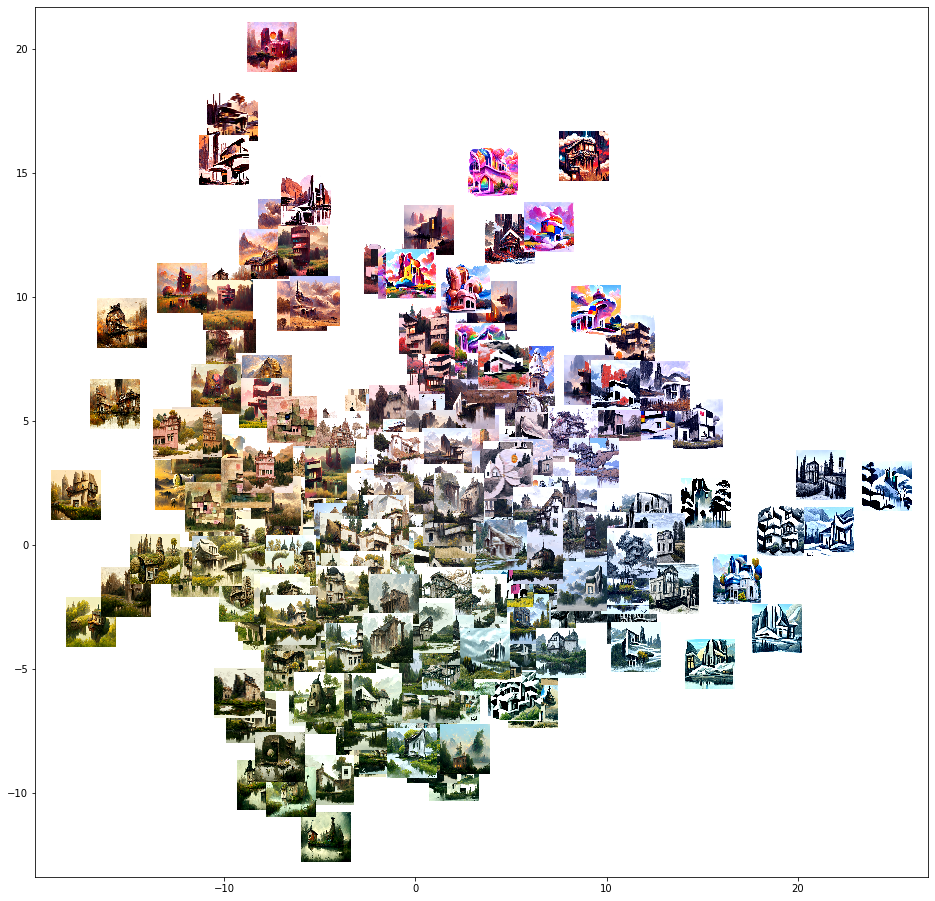

In [312]:
show_xy_images(pcs_ponds_df, imgs = art_loader.art_list[ponds_mask])

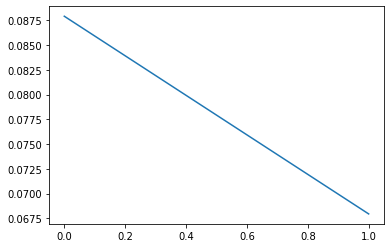

In [88]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
# pca only buildings
from sklearn.decomposition import PCA
num_pcs = 2
pca = PCA(num_pcs)
pcs_buildings = pca.fit_transform(many_colour_buildings)

pcs_buildings_dict = {f'pc{i+1}': pcs_buildings[:, i] for i in range(num_pcs)}
pcs_buildings_dict['artist'] = np.array(artist_list)[buildings_mask]

pcs_buildings_df = pd.DataFrame(pcs_buildings_dict)

In [ ]:
pcs_buildings_df

In [ ]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
# tsne only ponds
from sklearn.manifold import TSNE

import pandas as pd
num_tsne = 2
tsne = TSNE(num_tsne, perplexity = 7.0)
tsne_ponds = tsne.fit_transform(ponds)

tsne_ponds_dict = {f'pc{i+1}': tsne_ponds[:, i] for i in range(num_tsne)}
tsne_ponds_dict['artist'] = np.array(artist_list)[ponds_mask]

tsne_ponds_df = pd.DataFrame(tsne_ponds_dict)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
# tsne only buildings
from sklearn.manifold import TSNE

import pandas as pd
num_tsne = 2
tsne = TSNE(num_tsne, perplexity = 7.0)
tsne_buildings = tsne.fit_transform(buildings)

tsne_buildings_dict = {f'pc{i+1}': tsne_buildings[:, i] for i in range(num_tsne)}
tsne_buildings_dict['artist'] = np.array(artist_list)[buildings_mask]

tsne_buildings_df = pd.DataFrame(tsne_buildings_dict)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
# import umap

# reducer = umap.UMAP()

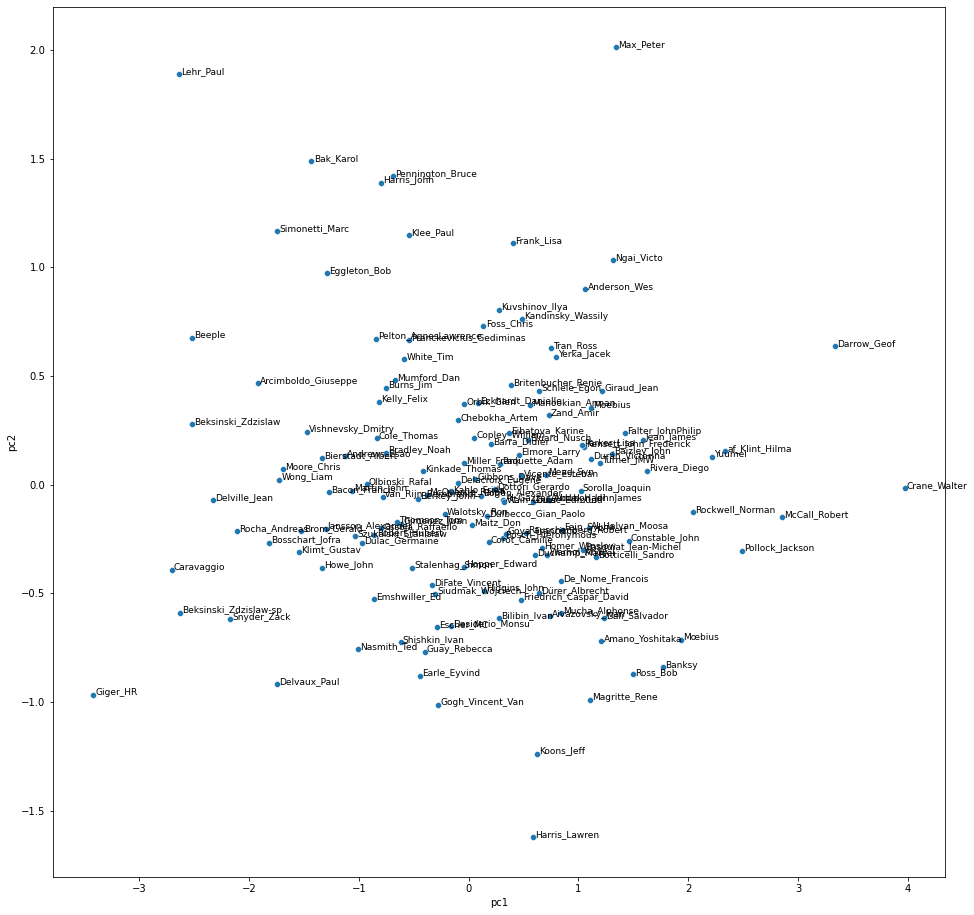

In [ ]:
# create labelled scatterplot
artist_df = pcs_ponds_df.groupby(['artist']).mean().reset_index()

fig , ax = plt.subplots(figsize = (16, 16))
sns.scatterplot(data = artist_df, x = 'pc1', y = 'pc2', ax = ax)

for i, point in artist_df.iterrows():
        ax.text(point['pc1']+.02, point['pc2'], str(point['artist']), size = '9')

In [ ]:
#from tensorflow.keras.utils import array_to_img
#array_to_img(ponds_list[0]).resize((64, 64))

## plotting images onto pc coords

In [122]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.image import resize


def show_xy_images(in_df, imgs, image_zoom=1):
    fig, ax1 = plt.subplots(1,1, figsize=(16, 16))
    artists = []
    for idx, c_row in tqdm(in_df.reset_index().iterrows()):
        #c_img = Image.open(c_row['path']).resize((64, 64))
        c_img = resize(img_to_array(imgs[idx]), [50,50]) / 255.0
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (c_row['pc1'], c_row['pc2']), xycoords='data', frameon=False)
        artists.append(ax1.add_artist(ab))
    ax1.update_datalim(in_df[['pc1', 'pc2']])
    ax1.autoscale()
    #ax1.axis('off')
#show_xy_images(pcs_df[ponds], imgs = np.array(ponds_list, dtype=object)[ponds])

475it [00:03, 121.19it/s]


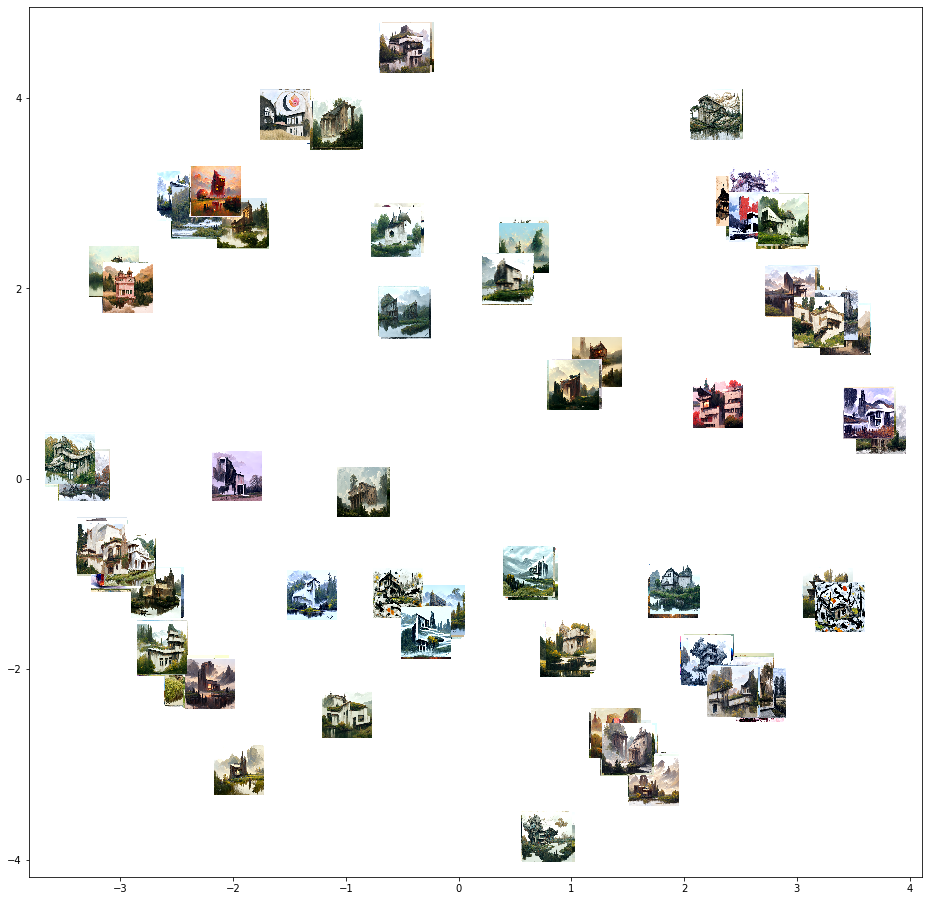

In [ ]:
show_xy_images(pcs_ponds_df, imgs = art_list[ponds_mask])

475it [00:04, 110.78it/s]


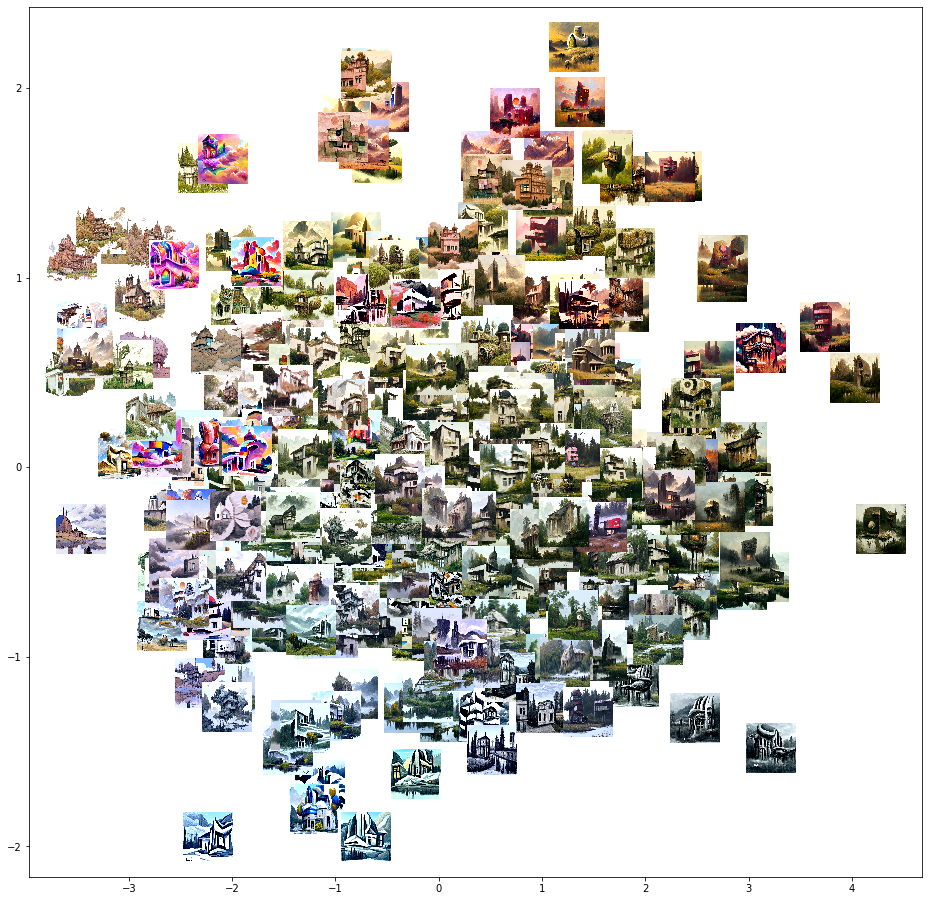

In [ ]:
show_xy_images(pcs_buildings_df, imgs = art_list[buildings_mask])

437it [00:03, 123.81it/s]


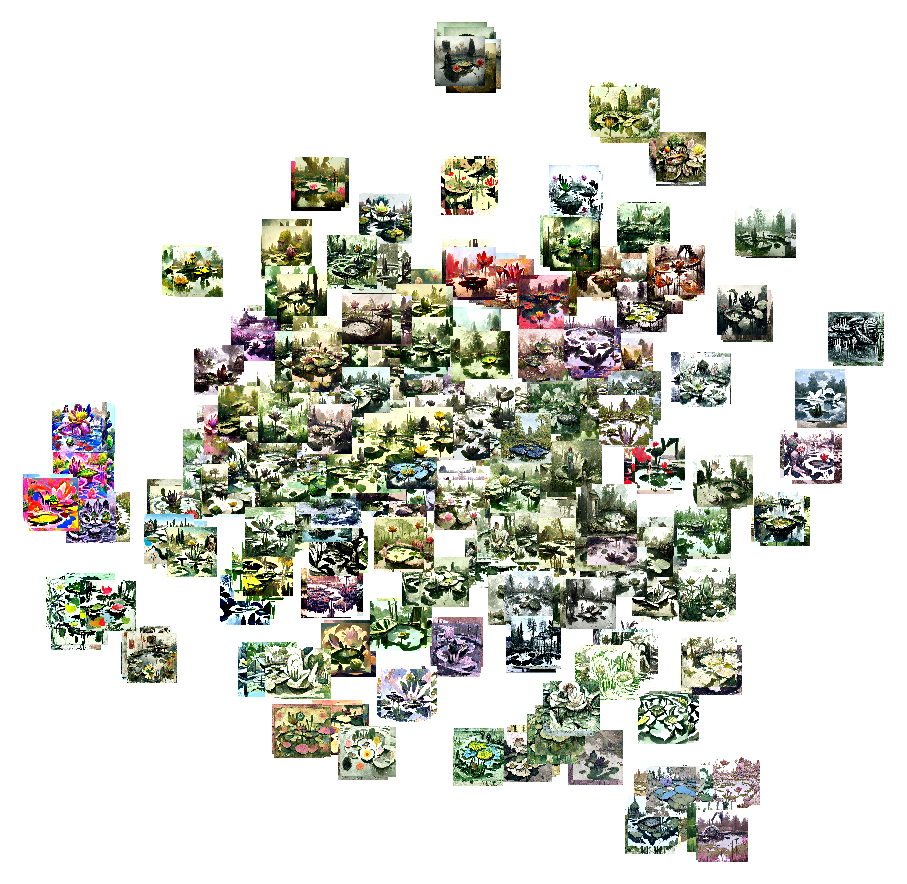

In [ ]:
show_xy_images(tsne_ponds_df, imgs = art_list[ponds_mask])

In [ ]:
show_xy_images(tsne_buildings_df, imgs = art_list[buildings_mask])

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.array(ponds_list)[0].astype(int))

In [ ]:
# resize
# get features

In [ ]:
# just add pil images to a list, have a later funtion to convert them all to an array

In [ ]:
# preprocess data properly

In [ ]:
# prompts
artist = ""
pond = f'A beautiful painting of a waterlily pond, {artist}, Trending on artstation'
building = f'A beautiful painting of a building in a serene landscape, {artist}, Trending on artstation'

In [ ]:
# idea for showing the images
# https://www.kaggle.com/code/kmader/hurricane-damage-overview

In [ ]:
# def color_count_feature(in_path):
#     raw_image = Image.open(in_path) 
#     web_image = raw_image.convert('P', palette='WEB', dither=None)
#     counts, bins = np.histogram(np.array(web_image).ravel(), bins=np.arange(256))
#     return counts*1.0/np.prod(web_image.size) # normalize output

# image_df['color_features'] = image_df['path'].progress_map(color_count_feature)
